In [1]:
%matplotlib inline

In [2]:
import os
import asyncio
import numpy as np
import matplotlib.pyplot as plt

import asyncmd

import aimmd
import aimmd.distributed as aimmdd

Could not initialize SLURM cluster handling. If you are sure SLURM (sinfo/sacct/etc) is available try calling `asyncmd.config.set_slurm_settings()` with the appropriate arguments.
/home/tb/hejung/.conda/envs/aimmd_distributed_devel/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Tensorflow/Keras not available


In [3]:
from state_funcs_mda import descriptor_func_psi_phi

wrapped_psi_phi = asyncmd.trajectory.PyTrajectoryFunctionWrapper(descriptor_func_psi_phi)

In [4]:
traj = asyncmd.Trajectory(structure_file="gmx_infiles/ala_300K_amber99sb-ildn.tpr",
                          trajectory_files="gmx_infiles/TP_low_barrier_300K_amber99sbildn.trr")

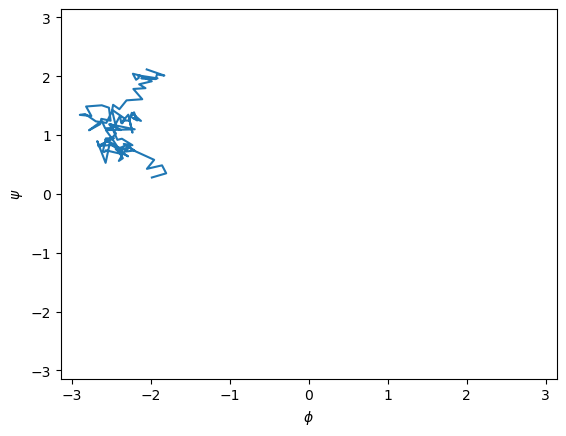

In [5]:
fig, axs = plt.subplots()

psi_phi = await wrapped_psi_phi(traj)

axs.plot(psi_phi[:, 1], psi_phi[:, 0])
axs.set_ylabel("$\psi$")
axs.set_xlabel("$\phi$")
axs.set_xlim(-np.pi, np.pi)
axs.set_ylim(-np.pi, np.pi);

## Setup one umbrella window on the top of the barrier

In [6]:
mdconfig = asyncmd.gromacs.MDP("gmx_infiles/md.mdp")

In [7]:
# have a look at the mdp
print(mdconfig)

<class 'asyncmd.gromacs.mdconfig.MDP'> has been changed since parsing: False
Current content:
----------------
title : ['test']
cpp : ['/lib/cpp']
include : ['-I../top']
define : []
integrator : md-vv
dt : 0.002
nsteps : -1
nstxout : 0
nstvout : 0
nstlog : 20
nstxout-compressed : 20
nstlist : 50
ns-type : grid
cutoff-scheme : Verlet
rlist : 1.1
coulombtype : PME
rcoulomb : 1.1
rvdw : 1.1
tcoupl : v-rescale
tc-grps : ['Protein', 'SOL']
tau-t : [0.5, 0.5]
ref-t : [300.0, 300.0]
Pcoupl : C-rescale
tau-p : 1.0
compressibility : [4.5e-05]
ref-p : [1.0]
gen-vel : no
gen-temp : 300.0
gen-seed : 173529
constraints : h-bonds



In [9]:
# add the pulling/harmonic potential
mdconfig["pull"] = "yes"
mdconfig["pull-nstxout"] = 1000
mdconfig["pull-nstfout"] = 1000
mdconfig["pull-ngroups"] = 4  # we have 4 atoms in the dihedral
mdconfig["pull-ncoords"] = 1  # we build 1 pull coord from the 4 groups
# our 4 atoms defining the psi dihedral
mdconfig["pull-group1-name"] = "psi_at1"
mdconfig["pull-group2-name"] = "psi_at2"
mdconfig["pull-group3-name"] = "psi_at3"
mdconfig["pull-group4-name"] = "psi_at4"
mdconfig["pull-coord1-type"] = "umbrella"  # make it a harmonic potential
mdconfig["pull-coord1-geometry"] = "dihedral"  # around the dihedral
mdconfig["pull-coord1-groups"] = ["1", "2", "2", "3", "3", "4"]  # defined by our 4 atoms
mdconfig["pull-coord1-init"] = "80"  # reference angle in degree
mdconfig["pull-coord1-k"] = "75"  # force constant in kJ/ (mol * rad**2) ....however thought it would be smart to use degree and radians together!?
# 150 kJ/ (mol * rad**2) was okayish
# also set our output frequency a bit down sp we get more independent configurations
mdconfig["nstxout-compressed"] = 1000
# same for loggign frequency
mdconfig["nstlog"] = 2000

### Find a starting configuration close to our window center

In [10]:
psi_vals = psi_phi[:, 0]

closest_idx = np.argmin((psi_vals - 80 * np.pi/180)**2)

print(f" psi, phi values for starting frame are {psi_phi[closest_idx]} at frame index {closest_idx}.")

 psi, phi values for starting frame are [ 1.38717069 -2.21372452] at frame index 75.


### Extract the frame and write it to the folder

In [11]:
wdir = "/homeloc/scratch/aimmd_distributed/UmbrellaSampling"

if not os.path.exists(wdir):
    os.makedirs(wdir)

extractor = asyncmd.trajectory.convert.RandomVelocitiesFrameExtractor(T=mdconfig["ref-t"][0])
starting_conf = extractor.extract(outfile=os.path.join(wdir, "starting_frame.trr"),
                                  traj_in=traj,
                                  idx=closest_idx,
                                  overwrite=True,
                                  )

### Now setup the engine and run it

In [12]:
engine = asyncmd.gromacs.GmxEngine(mdconfig=mdconfig,
                                   gro_file="gmx_infiles/conf.gro",
                                   top_file="gmx_infiles/topol_amber99sbildn.top",
                                   ndx_file="gmx_infiles/index.ndx",
                                   output_traj_type="XTC",
                                   mdrun_extra_args="-ntomp 4", 
                                   )

In [13]:
await engine.prepare(starting_configuration=starting_conf, workdir=wdir, deffnm="US")

In [14]:
out_traj = await engine.run_steps(nsteps=1e6)

/home/tb/hejung/.conda/envs/aimmd_distributed_devel/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:241: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


### Have a look at the density of configurations in the $\phi$-$\psi$-plane

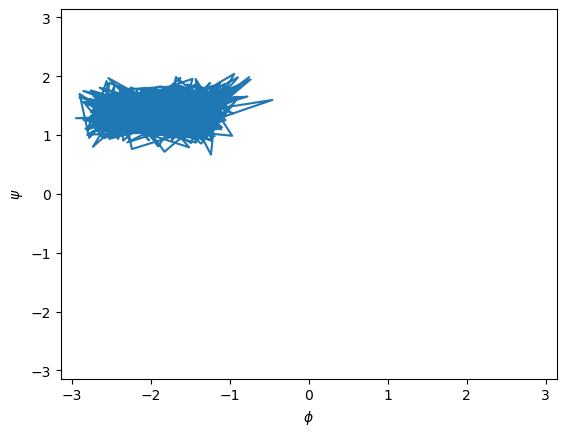

In [15]:
fig, axs = plt.subplots()

psi_phi = await wrapped_psi_phi(out_traj)

axs.plot(psi_phi[:, 1], psi_phi[:, 0], )#bins=50, range=[[-np.pi, np.pi], [-np.pi, np.pi]])
axs.set_ylabel("$\psi$")
axs.set_xlabel("$\phi$")
axs.set_xlim(-np.pi, np.pi)
axs.set_ylim(-np.pi, np.pi);

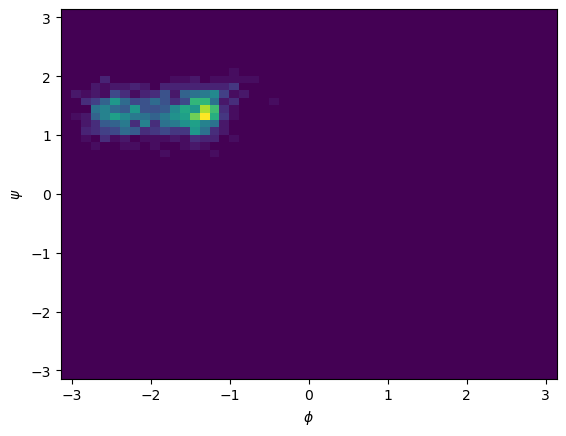

In [16]:
fig, axs = plt.subplots()

psi_phi = await wrapped_psi_phi(out_traj)

axs.hist2d(psi_phi[:, 1], psi_phi[:, 0], bins=50, range=[[-np.pi, np.pi], [-np.pi, np.pi]])
axs.set_ylabel("$\psi$")
axs.set_xlabel("$\phi$")
axs.set_xlim(-np.pi, np.pi)
axs.set_ylim(-np.pi, np.pi);